In [1]:
%matplotlib inline

import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
import matplotlib.pyplot as plt
import gzip
import pickle
import sys, os

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
from miniflow import *

In [2]:
train_img_file = '../mnist_data/train-images-idx3-ubyte.gz'
train_label_file = '../mnist_data/train-labels-idx1-ubyte.gz'
test_img_file = '../mnist_data/t10k-images-idx3-ubyte.gz'
test_label_file = '../mnist_data/t10k-labels-idx1-ubyte.gz'

save_file = '../mnist_data/mnist.pkl'

In [3]:
def read_image(fname):
    with gzip.open(fname, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, 784)
    
    return data

def read_label(fname):
    with gzip.open(fname, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
        
    return data

def create_pkl(save_file, data):
    if os.path.exists(save_file):
        return
    
    with open(save_file, 'wb') as f:
        pickle.dump(data, f)

In [4]:
mnist_data = {}
mnist_data['train_img'] = read_image(train_img_file)
mnist_data['train_label'] = read_label(train_label_file)
mnist_data['test_img'] = read_image(test_img_file)
mnist_data['test_label'] = read_label(test_label_file)

create_pkl(save_file, mnist_data)

In [5]:
# Load data
with open(save_file, 'rb') as f:
    data = pickle.load(f)

X_train, y_train = data['train_img'], data['train_label']
X_test, y_test = data['test_img'], data['test_label']

In [6]:
def normalized(data):
    data = data.astype(np.float32)
    return data / 255.

In [7]:
# Normalized data
X_train = normalized(X_train)
X_test = normalized(X_test)

In [8]:
def one_hot(data, n):
    one_hot_encoding = np.zeros([data.shape[-1], n])
    one_hot_encoding[np.arange(data.shape[-1]), data] = 1 
    
    return one_hot_encoding

In [9]:
#y_train = one_hot(y_train, 10)
#y_test = one_hot(y_test, 10)

In [10]:
# Split data
t = int(X_train.shape[0] * 0.9)
X_train, X_validation = X_train[:t], X_train[t:]
y_train, y_validation = y_train[:t], y_train[t:]

print("Train: ", X_train.shape, y_train.shape)
print("Test: ", X_test.shape, y_test.shape)
print("Validation: ", X_validation.shape, y_validation.shape)

Train:  (54000, 784) (54000,)
Test:  (10000, 784) (10000,)
Validation:  (6000, 784) (6000,)


In [11]:
n_input = X_train.shape[1]
n_output = 10
n_hidden1 = 64
n_hidden2 = 128

In [12]:
W1_ = np.random.randn(n_input, n_hidden1)
b1_ = np.random.randn(n_hidden1)

W2_ = np.random.randn(n_hidden1, n_hidden2)
b2_ = np.random.randn(n_hidden2)

W3_ = np.random.randn(n_hidden2, n_output)
b3_ = np.random.randn(n_output)

In [13]:
X, y = Input(name='X'), Input(name='y')  
W1, b1 = Input(name='W1'), Input(name='b1')  
W2, b2 = Input(name='W2'), Input(name='b2')  
W3, b3 = Input(name='W3'), Input(name='b3')  

In [14]:
l1 = Linear(X, W1, b1, name='l1')
s1 = Sigmoid(l1, name='s1')
l2 = Linear(s1, W2, b2, name='l2')
s2 = Sigmoid(l2, name='s2')
l3 = Linear(s2, W3, b3, name='l3')
cost = SoftmaxCrossEntropy(y, l3, name='loss')

In [15]:
feed_dict = {
    X: X_train,
    y: y_train,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_,
    W3: W3_,
    b3: b3_
}

In [16]:
# Hyperparameter
epochs = 200
lr = 0.001
batch_size = 100

In [17]:
m = X_train.shape[0]
steps_per_epoch = m // batch_size
graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2, W3, b3]
losses = {'train': [], 'validation': []}

In [18]:
# Training
for i in range(epochs):
    train_loss = 0
    val_loss = 0
    for j in range(steps_per_epoch):
        X_batch, y_batch = resample(X_train, y_train, n_samples=batch_size)
        X.value, y.value = X_batch, y_batch
        
        forward_and_backward(graph)
        sgd_update(trainables, lr)
        train_loss += graph[-1].value
        
    train_loss = train_loss / steps_per_epoch
    losses['train'].append(train_loss)
    
    X.value, y.value = X_validation, y_validation
    forward_and_backward(graph, training=False)
    val_loss = graph[-1].value
    losses['validation'].append(val_loss)
    
    #if (i+1) % batch_size == 0:
    print("Epoch: {}, Train Loss: {:.3f}, Validation Loss: {:.3f}".format(i+1, train_loss, val_loss))

Epoch: 1, Train Loss: 10.889, Validation Loss: 7.690
Epoch: 2, Train Loss: 6.664, Validation Loss: 5.846
Epoch: 3, Train Loss: 5.333, Validation Loss: 4.905
Epoch: 4, Train Loss: 4.596, Validation Loss: 4.251
Epoch: 5, Train Loss: 3.964, Validation Loss: 3.688
Epoch: 6, Train Loss: 3.517, Validation Loss: 3.316
Epoch: 7, Train Loss: 3.227, Validation Loss: 3.086
Epoch: 8, Train Loss: 3.013, Validation Loss: 2.899
Epoch: 9, Train Loss: 2.880, Validation Loss: 2.733
Epoch: 10, Train Loss: 2.718, Validation Loss: 2.585
Epoch: 11, Train Loss: 2.587, Validation Loss: 2.454
Epoch: 12, Train Loss: 2.480, Validation Loss: 2.336
Epoch: 13, Train Loss: 2.359, Validation Loss: 2.230
Epoch: 14, Train Loss: 2.271, Validation Loss: 2.135
Epoch: 15, Train Loss: 2.170, Validation Loss: 2.049
Epoch: 16, Train Loss: 2.103, Validation Loss: 1.972
Epoch: 17, Train Loss: 2.025, Validation Loss: 1.901
Epoch: 18, Train Loss: 1.981, Validation Loss: 1.836
Epoch: 19, Train Loss: 1.903, Validation Loss: 1.777
E

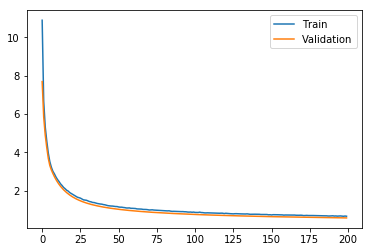

In [19]:
fig, ax = plt.subplots()
x = np.arange(len(losses['train']))
ax.plot(x, losses['train'], label='Train')
ax.plot(x, losses['validation'], label='Validation')
ax.legend()

In [36]:
# Test
feed_dict[X] = X_test
feed_dict[y] = y_test

graph = topological_sort(feed_dict)
forward_and_backward(graph, training=False)
loss = graph[-1].value
prediction = graph[-2].value.argmax(axis=1)
accuracy = prediction == y_test
accuracy = np.sum(accuracy) / accuracy.shape[0]

print("Test loss: {:.3f}".format(loss))
print("Accuracy: {:.3f}".format(accuracy))

Test loss: 0.662
Accuracy: 0.791
